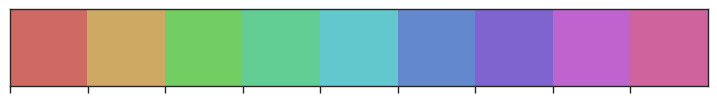

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import numba
from scipy import signal
from tqdm import tqdm


sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)
sns.palplot(colors)

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]


In [17]:


@numba.njit
def x_dot_init(x, y, V, params):
    dxdt = params[0]*V - (params[1] + params[3]) * x + params[2]/(V**2) * x**2 * y
    return dxdt

@numba.njit
def y_dot_init(x, y, V, params):
    dydt = params[1]*x - params[2]/(V**2) * x**2 * y
    return dydt

@numba.njit(fastmath=True)
def gillespie(x, y, t_max, b_place=5.5, V=100):

    t = 0
    click = 1
    t_list = [0]
    x_list = [x]
    y_list = [y]

    a = 2 * V
    c = 1/V**2
    d = 1
    
    
    while t < t_max:
        # rates
        x_spawn = a
        x_to_y = b_place * x
        y_to_x = c * x * (x-1) * y
        x_despawn = d * x
        
        rates = np.array([x_spawn, x_to_y, y_to_x, x_despawn])

        r_sum = np.cumsum(rates)
        R = np.sum(rates)
        u = np.random.uniform(0, R)
        dt = -np.log(np.random.uniform())/R


        mask = r_sum > u
        index = np.where(mask == True)[0][0]

        if index == 0:
            x += 1

        elif index == 1:
            x -= 1
            y += 1

        elif index == 2:
            y -= 1
            x += 1

        elif index == 3:
            x -= 1
        
        t += dt
        ts = 0.1
        if t > ts*click:
            t_list.append(t)
            x_list.append(x/V)
            y_list.append(y/V)
            click += 1

        #t_list.append(t)
        #x_list.append(x)
        #y_list.append(y)

    return np.array(t_list), np.array(x_list), np.array(y_list)


def euler_init(var_change, V, dt, t_max, params):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot_init(x, y, V, params)
        y += dt * y_dot_init(x, y, V, params)
        t += dt
    return np.array(x_list), np.array(y_list), np.array(t_list)

In [27]:
var_change = np.array([0, 0])
dt = 0.001
t_max =50
V = 1000
a = 2; b=4.5 ; c=1 ; d=1
params = np.array([a, b, c, d])


t_gil, x_gil, y_gil = gillespie(var_change[0], var_change[1], t_max, b_place=4.5, V=V)

x_eul, y_eul, t_eul = euler_init(var_change, V, dt, t_max, params)
x_eul = x_eul/V
y_eul = y_eul/V

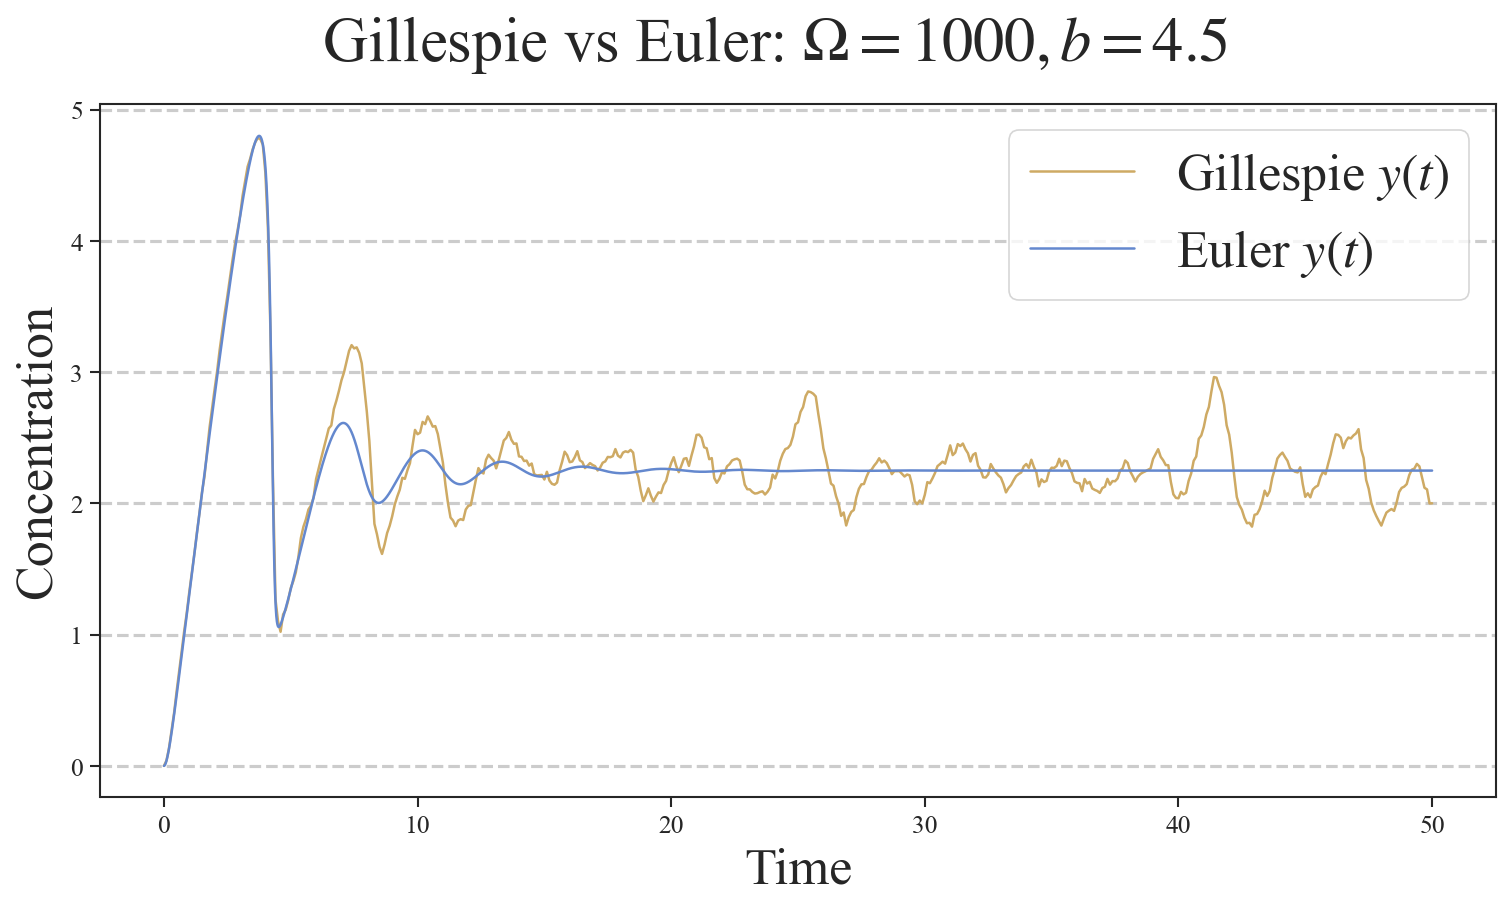

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(t_gil, y_gil, label=r'Gillespie $y(t)$', color=colors[1])
ax.plot(t_eul, y_eul, label=r'Euler $y(t)$', color=colors[5])
ax.set_xlabel('Time', fontsize = 25)
ax.set_ylabel('Concentration', fontsize = 25)
ax.legend(fontsize=25)

plt.suptitle(fr'Gillespie vs Euler: $\Omega = {V}, b={4.5}$', fontsize = 30)
plt.savefig('figurer/gillespie_vs_euler.png')


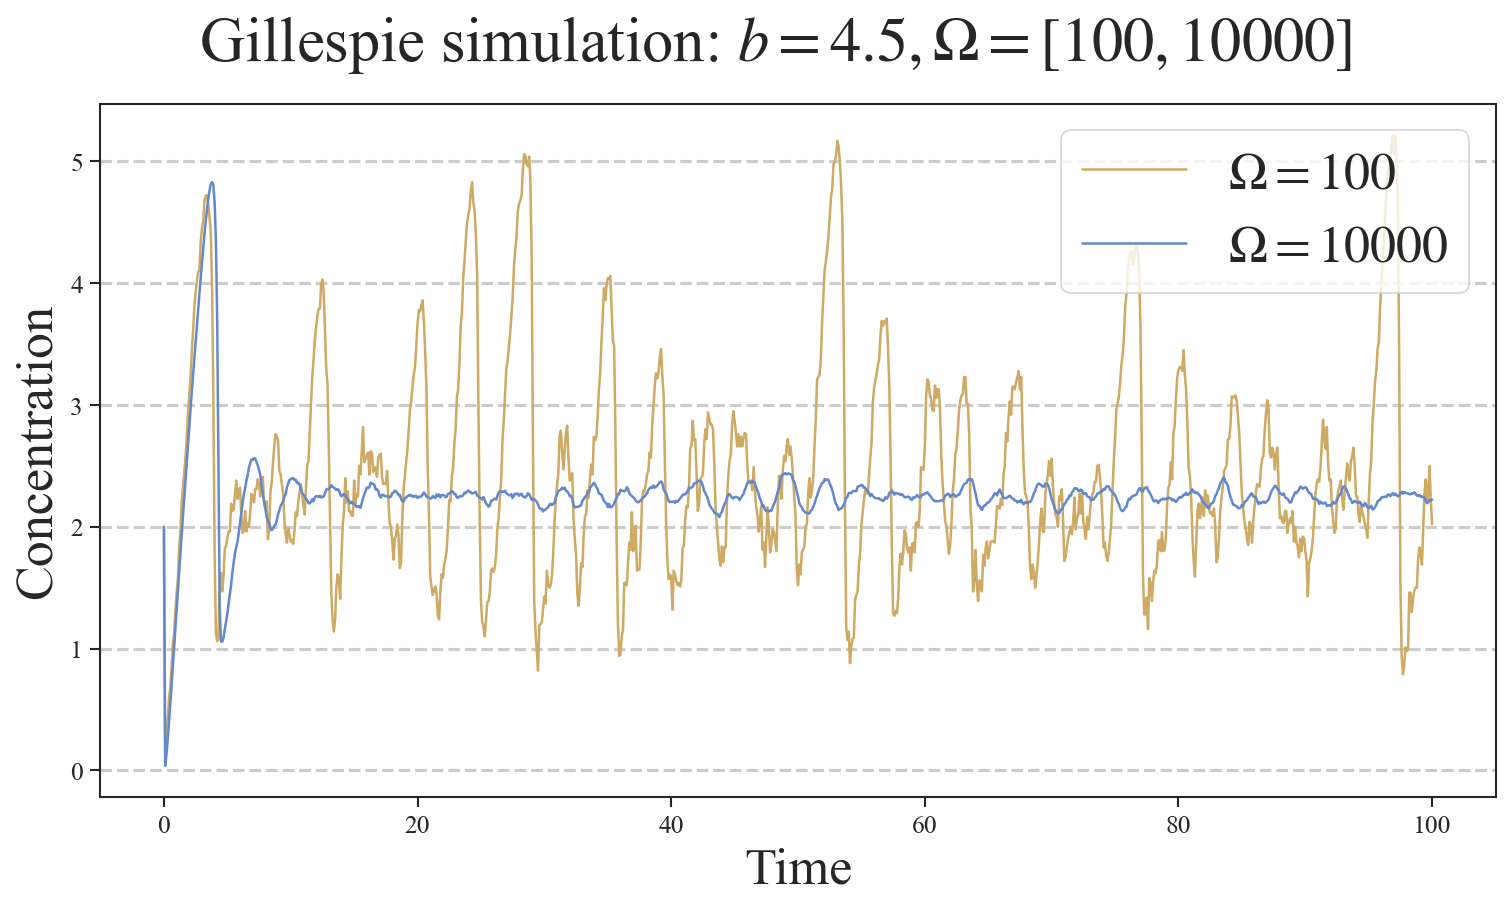

In [42]:
# Run gillespie simulation for two values of V

V = [100, 10000]
b = 4.5
t_max = 100
var_change = np.array([2, 2])

t_array = []
y_array = []
for i in V:
    t, x, y = gillespie(var_change[0], var_change[1], t_max, b_place=b, V=i)
    t_array.append(t)
    y_array.append(y)


# fig, ax = plt.subplots(1,2,figsize=(12, 6))
# for i in range(2):
#     if i == 0:
#         ax[i].plot(t_array[i], y_array[i], label=fr'$\Omega = {V[i]}$', color=colors[1])
#     else:
#         ax[i].plot(t_array[i], y_array[i], label=fr'$\Omega = {V[i]}$', color=colors[5])
# 
#     ax[i].set_xlabel('Time', fontsize = 25)
#     ax[i].set_ylabel('Concentration', fontsize = 25)
#     ax[i].legend(fontsize=25)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t_array[0], y_array[0], label=fr'$\Omega = {V[0]}$', color=colors[1])
ax.plot(t_array[1], y_array[1], label=fr'$\Omega = {V[1]}$', color=colors[5])
ax.set_xlabel('Time', fontsize = 25)
ax.set_ylabel('Concentration', fontsize = 25)
ax.legend(fontsize=25, loc='upper right')

plt.suptitle(fr'Gillespie simulation: $b={b}, \Omega = [100, 10000]$', fontsize = 30)
plt.savefig('figurer/resonance_vol.png')